In [113]:
import tensorflow as tf
import os

In [114]:
tf.__version__

'2.1.0'

In [115]:
dataset = tf.data.TFRecordDataset(os.path.join('.','unaugumented_image_mask.tfrecords'))

In [116]:
def convert_example_to_sample(example):
    
    features_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    
    sample = tf.io.parse_single_example(example, features_description)
    sample['image'] = tf.io.decode_jpeg(sample['image'])
    sample['mask'] = tf.io.decode_jpeg(sample['mask'])
    
    return sample

In [117]:
dataset = dataset.map(convert_example_to_sample)

In [118]:
from plotting import plot_image_grid

In [119]:
dataset_top = dataset.batch(4).__iter__()
dataset_top = next(dataset_top)

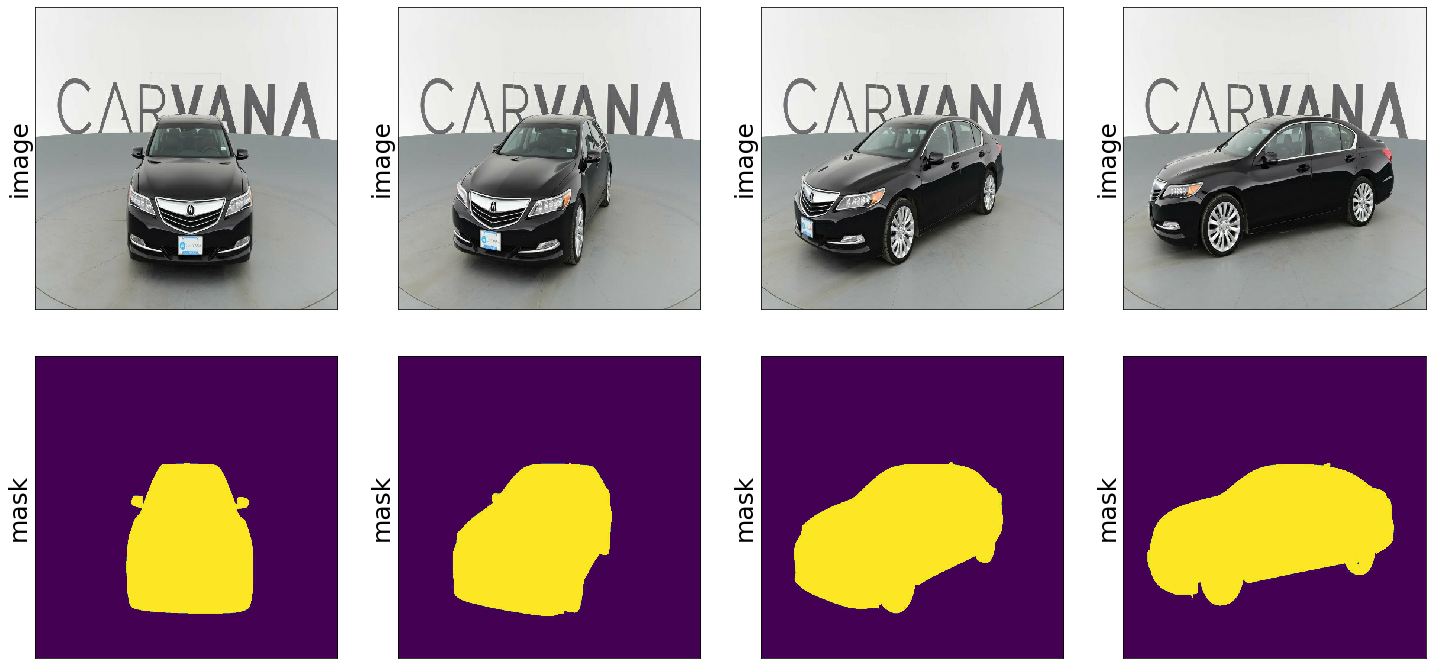

In [121]:
fig = plot_image_grid([dataset_top['image'].numpy(), dataset_top['mask'].numpy().reshape(-1,512,512)], 
                      titles=['image','mask'], transpose=True)

In [122]:
dataset_top

{'image': <tf.Tensor: shape=(4, 512, 512, 3), dtype=uint8, numpy=
 array([[[[243, 244, 238],
          [243, 244, 238],
          [240, 241, 235],
          ...,
          [243, 243, 243],
          [243, 243, 243],
          [243, 243, 243]],
 
         [[242, 243, 237],
          [243, 244, 238],
          [241, 242, 236],
          ...,
          [242, 242, 242],
          [242, 242, 242],
          [243, 243, 243]],
 
         [[242, 243, 237],
          [242, 243, 237],
          [241, 242, 236],
          ...,
          [243, 243, 243],
          [243, 243, 243],
          [243, 243, 243]],
 
         ...,
 
         [[179, 183, 182],
          [179, 183, 182],
          [177, 181, 180],
          ...,
          [174, 178, 177],
          [175, 179, 178],
          [175, 179, 178]],
 
         [[179, 183, 182],
          [178, 182, 181],
          [177, 181, 180],
          ...,
          [174, 178, 177],
          [174, 178, 177],
          [174, 178, 177]],
 
         [[178, 18

In [82]:
batch_size = 8
num_epochs = 90
image_size = [512,512]
num_channels = 3
num_classes = 1
random_seed = 42
num_show = 3

In [83]:
dataset

<MapDataset shapes: {image: (None, None, None), mask: (None, None, None)}, types: {image: tf.uint8, mask: tf.uint8}>

In [84]:
d_dataset = dataset.batch(batch_size)

In [85]:
d_dataset

<BatchDataset shapes: {image: (None, None, None, None), mask: (None, None, None, None)}, types: {image: tf.uint8, mask: tf.uint8}>

In [86]:
train_steps_per_epoch = tf.math.ceil(5088 / batch_size)

In [87]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Lambda, Dropout, 
                                     MaxPooling2D, LeakyReLU, concatenate, BatchNormalization)

In [88]:
def unet_conv_block(x, filters, kernel_size=3, batch_norm=True, dropout=False,
                    name_prefix="enc_", name_suffix=0):
    """
    Pass the input tensor through 2 Conv layers with LeakyReLU activation + opt. through
    BatchNorm and Dropout layers.
    :param x:                       Input tensor.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param batch_norm:              Flag to apply batch normalization.
    :param dropout:                 Flag to apply dropout.
    :param name_prefix:             Prefix for the layers' names.
    :param name_suffix:             Suffix for the layers' names.
    :return:                        Transformed tensor.
    """
    name_fn = lambda layer, num: '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)

    # First convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 1))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 1))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 1))(x)
    if dropout:
        x = Dropout(0.2, name=name_fn('drop', 1))(x)

    # Second convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 2))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 2))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 2))(x)

    return x


def unet_deconv_block(x, filters, kernel_size=2, strides=2, batch_norm=True, dropout=False,
                      name_prefix="dec_", name_suffix=0):
    """
    Pass the input tensor through 1 Conv layer and 1 transposed (de)Conv layer with LeakyReLU
    activation + opt. through BatchNorm and Dropout layers.
    :param x:                       Input tensor.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param strides:                 Strides for transposed convolution.
    :param batch_norm:              Flag to apply batch normalization.
    :param dropout:                 Flag to apply dropout.
    :param name_prefix:             Prefix for the layers' names.
    :param name_suffix:             Suffix for the layers' names.
    :return:                        Transformed tensor.
    """
    name_fn = lambda layer, num: '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)

    # First convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 1))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 1))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 1))(x)
    if dropout:
        x = Dropout(0.2, name=name_fn('drop', 1))(x)

    # Second (de)convolution:
    x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides,
                        activation=None, kernel_initializer='he_normal',
                        padding='same', name=name_fn('conv', 2))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 2))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 2))(x)

    return x


# As the dimensions of our images may not be normalized/even, it is possible that after 
# downsampling and upsampling, we do not reobtain the original size (with a difference 
# of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the generated
# image to the dimensions of the target one:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[1:3]),
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)


def unet(x, out_channels=3, layer_depth=4, filters_orig=32, kernel_size=4,
         batch_norm=True, final_activation='sigmoid'):
    """
    Pass the tensor through a trainable UNet.
    :param x:                       Input tensor.
    :param out_channels:            Number of output channels.
    :param layer_depth:             Number of convolutional blocks vertically stacked.
    :param filters_orig:            Number of filters for the 1st block (then multiplied by 2 
                                    every block).
    :param kernel_size:             Kernel size for layers.
    :param batch_norm:              Flag to apply batch normalization.
    :param final_activation:        Name/function for the last activation.
    :return:                        Output tensor.
    """
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        conv_block = unet_conv_block(x, filters, kernel_size,
                                     batch_norm=batch_norm, name_suffix=i)
        outputs_for_skip.append(conv_block)

        x = MaxPooling2D(2)(conv_block)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(x, filters, kernel_size, name_suffix='btleneck')

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        use_dropout = i < (layer_depth - 2)
        deconv_block = unet_deconv_block(x, filters, kernel_size,
                                         batch_norm=batch_norm,
                                         dropout=use_dropout, name_suffix=i)

        shortcut = outputs_for_skip[-(i + 1)]
        deconv_block = ResizeToSame(
            name='resize_to_same{}'.format(i))([deconv_block, shortcut])

        x = concatenate([deconv_block, shortcut], axis=-1,
                        name='dec_conc{}'.format(i))

    x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
               padding='same', name='dec_out1')(x)
    x = Dropout(0.3, name='drop_out1')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
               padding='same', name='dec_out2')(x)
    x = Dropout(0.3, name='drop_out2')(x)
    x = Conv2D(filters=out_channels, kernel_size=1, activation=final_activation,
               padding='same', name='dec_output')(x)

    return x

In [89]:
kernel_size = 4
filters_orig = 32
layer_depth = 4
use_batch_norm = batch_size > 1

In [90]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [91]:
inputs = Input(shape=(*image_size, num_channels))
outputs = unet(inputs, out_channels=num_classes,layer_depth=layer_depth,
              filters_orig=filters_orig, kernel_size=kernel_size, batch_norm=use_batch_norm,
              final_activation=None)
unet_model = Model(inputs, outputs)

In [92]:
from custom_loss_metrics import (SegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU, get_mask_for_valid_labels)

In [93]:
import collections
from keras_custom_callbacks import SimpleLogCallback

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

In [94]:
optimizer = tf.keras.optimizers.Adam()
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                    restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True),
    callback_simple_log
]

In [95]:
unet_model.compile(optimizer=optimizer, loss=SegmentationLoss(from_logits=True), 
                   metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

In [96]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
enc_conv0-1 (Conv2D)            (None, 512, 512, 32) 1568        input_4[0][0]                    
__________________________________________________________________________________________________
enc_bn0-1 (BatchNormalization)  (None, 512, 512, 32) 128         enc_conv0-1[0][0]                
__________________________________________________________________________________________________
enc_act0-1 (LeakyReLU)          (None, 512, 512, 32) 0           enc_bn0-1[0][0]                  
____________________________________________________________________________________________

In [101]:
dd_dataset = d_dataset.prefetch(1)
unet_model.fit(dd_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
              callbacks=callbacks, verbose=0)

ValueError: in converted code:

    /home/anonymous/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/anonymous/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home/anonymous/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:510 standardize_input_data
        'for each key in: ' + str(names))

    ValueError: No data provided for "input_4". Need data for each key in: ['input_4']


In [102]:
def read_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    
    sample = tf.io.parse_single_example(example, features)
    
    image = tf.image.decode_jpeg(sample['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = tf.image.decode_jpeg(sample['mask'], channels=1)
    mask = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, mask

In [109]:
def get_batched_dataset(filenames):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=4)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=4)
    
    dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    return dataset

In [110]:
def get_training_dataset():
    return get_batched_dataset('unaugumented_image_mask.tfrecords')

In [112]:
unet_model.fit(get_training_dataset(), steps_per_epoch=5088/8, epochs=num_epochs,
              callbacks=callbacks, verbose=0)

Training: start.
Training: end.


KeyError: 'loss'